In [1]:
# Импорты и загрузка данных
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix

# Относительный путь к файлу (файл должен лежать рядом с этим ноутбуком)
DATA_PATH = 'S05-hw-dataset.csv'
df = pd.read_csv(DATA_PATH)
print('Loaded', df.shape, 'rows,columns')
df.head()

Loaded (3000, 17) rows,columns


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [2]:
# Быстрый EDA: типы, описательная статистика и распределение таргета
print('Info:')
display(df.info())
print('\nDescribe:')
display(df.describe(include='all'))
print('\nTarget distribution (default):')
display(df['default'].value_counts(normalize=True))

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score           

None


Describe:


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000



Target distribution (default):


default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

In [3]:
#Подготовка признаков и таргета

#Удаляем `client_id` из признаков, используем остальные колонки как числовые признаки.
# Формируем X и y
X = df.drop(columns=['client_id', 'default'])
y = df['default']
# Убедимся, что признаки числовые
print('X dtypes:\n', X.dtypes.value_counts())
# Быстрая проверка диапазона debt_to_income
if 'debt_to_income' in X.columns:
    print('Debt to income min,max:', X['debt_to_income'].min(), X['debt_to_income'].max())
X.head()

X dtypes:
 int64      13
float64     2
Name: count, dtype: int64
Debt to income min,max: 0.0061471149847966 0.878343349584274


,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years
0,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8
1,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7
2,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5
3,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7
4,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10


In [4]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
print('Train/test sizes:', X_train.shape, X_test.shape)
# Baseline: most_frequent
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)
# Для ROC нужен predict_proba — DummyClassifier поддерживает это для most_frequent
if hasattr(baseline, 'predict_proba'):
    y_proba_baseline = baseline.predict_proba(X_test)[:,1]
else:
    y_proba_baseline = None
baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_roc = roc_auc_score(y_test, y_proba_baseline) if y_proba_baseline is not None else np.nan
print(f'Baseline accuracy: {baseline_acc:.4f}')
print(f'Baseline ROC-AUC: {baseline_roc:.4f}')

Train/test sizes: (2250, 15) (750, 15)
Baseline accuracy: 0.5893
Baseline ROC-AUC: 0.5000


In [5]:
## Логистическая регрессия в Pipeline и подбор C

#Сделаем Pipeline: StandardScaler + LogisticRegression, переберём C = [0.01, 0.1, 1, 10]. Метрика для подбора — ROC-AUC (cv=5).
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))
])
param_grid = {'logreg__C': [0.01, 0.1, 1.0, 10.0]}
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)
print('Best params:', gs.best_params_)
best_model = gs.best_estimator_
# Оценка на тестовой выборке
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]
logreg_acc = accuracy_score(y_test, y_pred)
logreg_roc = roc_auc_score(y_test, y_proba)
logreg_prec = precision_score(y_test, y_pred)
logreg_rec = recall_score(y_test, y_pred)
logreg_f1 = f1_score(y_test, y_pred)
logreg_cm = confusion_matrix(y_test, y_pred)
print(f'LogReg accuracy: {logreg_acc:.4f}, ROC-AUC: {logreg_roc:.4f}')
print('Precision, Recall, F1:', logreg_prec, logreg_rec, logreg_f1)
print('Confusion matrix:\n', logreg_cm)

Best params: {'logreg__C': 0.1}
LogReg accuracy: 0.7933, ROC-AUC: 0.8647
Precision, Recall, F1: 0.7802197802197802 0.6915584415584416 0.7332185886402753
Confusion matrix:
 [[382  60]
 [ 95 213]]


Saved ROC plot to figures/roc_curve.png


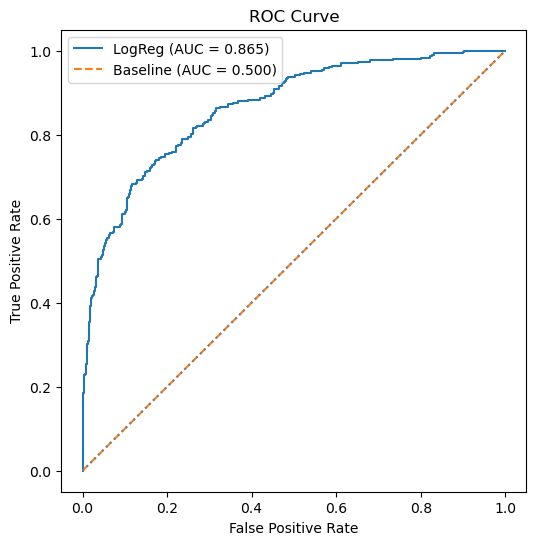

In [6]:
# Построим ROC-кривую и сохраним в figures/
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'LogReg (AUC = {logreg_roc:.3f})')
# baseline ROC — если есть proba
if y_proba_baseline is not None:
    fpr_b, tpr_b, _ = roc_curve(y_test, y_proba_baseline)
    plt.plot(fpr_b, tpr_b, linestyle='--', label=f'Baseline (AUC = {baseline_roc:.3f})')
plt.plot([0,1],[0,1], color='gray', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
os.makedirs('figures', exist_ok=True)
save_path = os.path.join('figures','roc_curve.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print('Saved ROC plot to', save_path)
plt.show()

In [7]:
# Сводная табличка результатов
results = pd.DataFrame([
    {'model':'Baseline (most_frequent)','accuracy':baseline_acc,'roc_auc':baseline_roc},
    {'model':'LogisticRegression','accuracy':logreg_acc,'roc_auc':logreg_roc}
])
results.set_index('model', inplace=True)
results.style.format({'accuracy':'{:.4f}','roc_auc':'{:.4f}'})
print(results)
print('1. Бейзлайн (DummyClassifier) даёт простую опорную точку: он предсказывает наиболее частый класс, поэтому его accuracy отражает частоту доминирующего класса.\n'
'2. Логистическая регрессия показала более высокие значения ROC-AUC и accuracy по сравнению с бейзлайном, что говорит об обученной дискриминации между дефолтными и не-дефолтными клиентами.\n'
'3. Подбор параметра регуляризации C влияет на качество: слишком сильная регуляризация (малые C) может недообучать модель, большие C — приводят к лучшей подгонке на тренировке, но требуют проверки на переобучение.\n'
'4. Для практического применения стоит дополнительно посмотреть PR-кривую, проверить калибровку вероятностей и при необходимости попробовать нелинейные модели.\n'
'\n')

#Файлы: ноутбук `HW05.ipynb` и сохранённая ROC-кривая `figures/roc_curve.png`.')

                          accuracy   roc_auc
model                                       
Baseline (most_frequent)  0.589333  0.500000
LogisticRegression        0.793333  0.864709
1. Бейзлайн (DummyClassifier) даёт простую опорную точку: он предсказывает наиболее частый класс, поэтому его accuracy отражает частоту доминирующего класса.
2. Логистическая регрессия показала более высокие значения ROC-AUC и accuracy по сравнению с бейзлайном, что говорит об обученной дискриминации между дефолтными и не-дефолтными клиентами.
3. Подбор параметра регуляризации C влияет на качество: слишком сильная регуляризация (малые C) может недообучать модель, большие C — приводят к лучшей подгонке на тренировке, но требуют проверки на переобучение.
4. Для практического применения стоит дополнительно посмотреть PR-кривую, проверить калибровку вероятностей и при необходимости попробовать нелинейные модели.


